# View Spectractor Results

- adaptation from **viewSpectractorResults.ipynb** in  ~/../../j/jneveu/rubin-user/holo_atmo/
- creation date : 2024-09-25
- last update :2024-09-25
- last update : 2024-09-30 : full extended
- last update : 2024-10-17 : repairs the calculation of jd and mjd by taking info.group : Fonctionne sur w_2024_38 et pas w_2024_41

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
from astropy.time import Time
import getCalspec
#%matplotlib widget 
%matplotlib inline

In [ ]:
def get_whereclause(expos_id):
    return f"exposure.id = {expos_id} and instrument = \'LATISS\'"

In [ ]:
from lsst.summit.utils.utils import checkStackSetup
checkStackSetup()

In [ ]:
#import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils
butler = butlerUtils.makeDefaultLatissButler(embargo=True)

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
#butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c and "SensorFlat" in c and "FixA1" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c and "SensorFlat" in c and "FixA1" in c:
        print(c)

## Check the presence of the spectra

In [ ]:
# my run 2024-09-24
#my_collection = ['u/dagoret/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder/20240924T161119Z']
# my run 2024-10-16
my_collection = ['u/dagoret/auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip/20241016T184601Z']
datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where= "instrument='LATISS'")

In [ ]:
my_collection_str = my_collection[0]
my_collection_str  = my_collection_str.replace('/','_') 
output_filename = my_collection_str+"_spectrfullextended.npy"
print(f" >>> output_filename = {output_filename}")

In [ ]:
where = "instrument='LATISS'" 
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))

refs = list(set(butler.registry.queryDatasets('spectractorSpectrum',  where=where,  collections=my_collection)))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [ ]:
print(len(records))
records[0]

In [ ]:
for i, r in enumerate(records):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",r.id)
    print("day_obs..................:",r.day_obs)
    print("target..................:",r.target_name)
    print("filt+disp..................:",r.physical_filter)

    # spec = butler.get('spectractorSpectrum', visit=r.id, detector=0, collections=my_collection, instrument='LATISS')
    
    if i>5:
        break

In [ ]:
# delete a collection
# butler.pruneDatasets(datasetRefs, disassociate=True, unstore=True, purge=True)

### Fetch additional info on the exposure
- in the butler registry

In [ ]:
df_exposure = pd.DataFrame(columns=['ex_id', 'ex_obs_id','ex_day_obs', 'ex_seq_num','ex_time_start','ex_time_end' ,'ex_type', 
                                    'ex_target','ex_filter','ex_expos','ex_tr_ra','ex_tr_dec',
                                    'ex_skyangle','ex_azimuth','ex_zenith','ex_science_program','ex_jd','ex_mjd'])

In [ ]:
for count, r in enumerate(records):
    the_whereclause = get_whereclause(r.id)
    for count2, info in enumerate(registry.queryDimensionRecords('exposure',where= the_whereclause)):
    
    
        try:
            df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num,pd.to_datetime(info.timespan.begin.to_string()),pd.to_datetime(info.timespan.end.to_string()) ,info.observation_type, info.target_name, info.physical_filter,  \
                             info.exposure_time,info.tracking_ra, info.tracking_dec, info.sky_angle,info.azimuth ,info.zenith_angle, info.science_program,
                             info.timespan.begin.jd,info.timespan.begin.mjd ]

            info_timespan_begin_to_string = info.timespan.begin.jd
            info_timespan_end_to_string = info.timespan.begin.mjd 
            
        except:
            print(">>>   Unexpected error:", sys.exc_info()[0])
            #info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
            #info_timespan_end_to_string = "2051-01-01 00:00:00.00"

            info_timespan_begin_to_string = info.group
            info_timespan_end_to_string = info.group

            info_timespan_begin_mjd  = Time(info_timespan_begin_to_string).mjd
            info_timespan_begin_jd = Time(info_timespan_begin_to_string).jd
            
            print("\t >>>> after error try to recover mjd and jd == > mjd, jd = ",info_timespan_begin_mjd ,info_timespan_begin_jd )
            
            
            #info_timespan_begin_jd = 0
            #info_timespan_begin_mjd = 0
            df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num,
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string) ,
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, \
                             info.exposure_time,info.tracking_ra, info.tracking_dec, info.sky_angle,info.azimuth ,info.zenith_angle, info.science_program,
                             info_timespan_begin_jd, info_timespan_begin_mjd  ]
 
    
        if count < 5:
            print("-----------------------------------------------------",count,"---------------------------------------------------------")
            print(info)
            print("\t id:                  ",info.id)
            print("\t day_obs:             ",info.day_obs)
            print("\t info_group.          ",info.group)
            print("\t seq_num:             ",info.seq_num)
            print("\t type-of-observation: ",info.observation_type)
            print("\t target:              ",info.target_name)
        
            #mjd = Time(info.timespan.begin.to_string()).mjd
            #jd = Time(info.timespan.begin.to_string()).jd
            #print("mjd, jd = ",info_timespan_begin_mjd,info_timespan_begin_mjd)

In [ ]:
df_exposure

## Load one spectrum

In [ ]:
my_collection

In [ ]:
dataId = {"day_obs": 20230117 	, "seq_num": 238, 'instrument':'LATISS',"detector": 0}
#dataId = {"day_obs": 20241015, "seq_num": 717, 'instrument':'LATISS',"detector": 0}
spec= butler.get('spectractorSpectrum',dataId,collections=my_collection)
p = butler.get('spectrumLibradtranFitParameters',dataId,collections=my_collection)
p

In [ ]:
_ = spec.plot_spectrum()

In [ ]:
#exp = butler.get('raw', dataId)
exp = butler.get('raw', dataId)
md = exp.getMetadata().toDict()
md

In [ ]:
spec.save_spectrum("./test_spectrum3.fits",overwrite="True")

In [ ]:
#fh[0].header["WINDSPD"] = 10
#fh[0].header["WINDSPD"]

## Load all Libradtran parameters

In [ ]:
dataId

In [ ]:
# see here an efficient way to access FITS headers: https://lsstc.slack.com/archives/CBV7K0DK6/p1700250222827499
params_spectrum = []
params_spectrogram = []
headers = []

def from_ref_to_dataId(ref):
    dataId = {'day_obs': ref.dataId["day_obs"], 'seq_num': int(str(ref.dataId["visit"])[8:]), 'instrument': 'LATISS', 'detector': 0}
    return dataId

for ref in tqdm(sorted(refs, key=lambda x: x.dataId["visit"])[::]):
    #try:
    with fits.open(butler.getURI(ref).geturl(),use_fsspec=True,
          fsspec_kwargs = {
              "endpoint_url": "https://s3dfrgw.slac.stanford.edu"              }
         ) as fh:
        hdr = fh[0].header
    exp = butler.get('raw', from_ref_to_dataId(ref))
    md = exp.getMetadata().toDict()
    hdr["WINDSPD"] = md["WINDSPD"]
    hdr["WINDDIR"] = md["WINDDIR"]
    headers.append(hdr)
    p = butler.get('spectrumLibradtranFitParameters', visit=ref.dataId["visit"], collections=my_collection, detector=0, instrument='LATISS')
    params_spectrum.append(p)
    p = butler.get('spectrogramLibradtranFitParameters', visit=ref.dataId["visit"], collections=my_collection, detector=0, instrument='LATISS')
    params_spectrogram.append(p)
   # except (ValueError,LookupError):
    #    print("Skip", ref.dataId["visit"])
    #    continue

In [ ]:
#def getit(butler, ref):
#    butler.get(ref)
#    return True

In [ ]:
#import concurrent.futures

In [ ]:
#refs = list(set(butler.registry.queryDatasets('spectrumLibradtranFitParameters',  where=where,  collections=my_collection)))

#get_executor = concurrent.futures.ProcessPoolExecutor(max_workers=4)
#future_get = {get_executor.submit(getit, butler, ref): ref for ref in refs}

In [ ]:
#all_results = {}
#for future in concurrent.futures.as_completed(future_get):
#    uri = future_get[future]
#    try:
#        exists = future.result()
#    except Exception as e:
#        print("Exception", e)
#        exists = False
#    all_results[uri] = exists

In [ ]:
len(params_spectrogram)

In [ ]:
import matplotlib
matplotlib.pyplot.close()

In [ ]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [ ]:
min_index = 0
max_index = np.inf

df1 = pd.DataFrame(columns=columns_spectrum)

for k, header in enumerate(headers):
    # if k > 40: break
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for h in header:
        if h in columns_spectrum:
            row[h] = header[h]
    df1.loc[len(df1)] = row
            
df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)

for k, p in enumerate(params_spectrogram):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df2.loc[len(df2)] = row
            
df3 = pd.DataFrame(columns=columns_spectrum_bestfit)

for k, p in enumerate(params_spectrum):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df3.loc[len(df3)] = row

In [ ]:
df3

In [ ]:
df = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df, df3, left_index=True, right_index=True)

In [ ]:
df

In [ ]:
df = pd.merge(df,df_exposure,left_index=True, right_index=True)

In [ ]:
df

In [ ]:
df.set_index('DATE-OBS', inplace=True)
#df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
df.index = pd.to_datetime(df.index) #['DATE-OBS'])
df.sort_index(inplace=True)
df

In [ ]:
pd.set_option('display.max_columns', None)
df

In [ ]:
rec = df.to_records()

In [ ]:
np.save(output_filename, rec)

In [ ]:
rec = np.load(output_filename, allow_pickle=True)
df = pd.DataFrame(rec)
pd.set_option('display.max_columns', None)

In [ ]:
df

In [ ]:
for col in ["D2CCD", "PIXSHIFT", "PSF_REG", "CHI2_FIT", "OUTPRESS", "OUTTEMP", "alpha_0_2", "TARGETX", "TARGETY"]:
    if col not in df.columns: continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure()
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"], rec[col], yerr=rec[col_err], linestyle="none", marker="+")
    else:
        plt.plot(rec["DATE-OBS"], rec[col], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col]), 1.1*np.max(rec[col])))
    if "PSF_REG" in col:
        plt.yscale("log")
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
filtered = (rec["CHI2_FIT"] < 30) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186.7)  & (rec["D2CCD"] < 187.4)  & (rec["PIXSHIFT"] > 0.5)  & (rec["PIXSHIFT"] < 1.5) 
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)

In [ ]:
len(filtered)

In [ ]:
np.sum(filtered)

In [ ]:
for col in ["D2CCD", "PIXSHIFT", "PSF_REG", "CHI2_FIT", "OUTPRESS", "OUTTEMP", "OUTHUM", "alpha_0_2", "TARGETX", "TARGETY"]:
    if col not in df.columns: continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure()
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"][filtered], rec[col][filtered], yerr=rec[col_err][filtered], linestyle="none", marker="+")
    else:
        plt.plot(rec["DATE-OBS"][filtered], rec[col][filtered], linestyle="none", marker="+")
    plt.ylim((0.9*np.nanmin(rec[col][filtered]), 1.1*np.nanmax(rec[col][filtered])))
    if "PSF_REG" in col:
        plt.yscale("log")
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

### Spectrum fits

In [ ]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [nm]", "B_y"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"][filtered], rec[col][filtered], yerr=rec[col_err][filtered], linestyle="none", marker="+")
    else:
        plt.plot(rec["DATE-OBS"][filtered], rec[col][filtered], linestyle="none", marker="+")
    #plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
filters = np.unique(rec["FILTER"])
filters

In [ ]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A1_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [nm]", "B_y"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for filt in filters:
        if filt in ["HD60753", "HD37962"]:
            continue
        index = filtered & (rec["FILTER"] == filt)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=filt)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
stars = np.unique(rec["TARGET"])
stars

In [ ]:
for col in ["A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "angstrom_exp_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [nm]", "B_y", "alpha_0_2", "alpha_0_1", "gamma_0_2", "gamma_0_1", "y_c_0_2", "y_c_0_1"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(10,6))
    for star in stars:
        #if star not in ["HD185975"]:
        #    continue
        index = filtered & (rec["TARGET"] == star)
        if not getCalspec.is_calspec(star):
            marker = "o"
        else:
            marker = "+"
        if col_err in df.columns and False:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker=marker, label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker=marker, label=star)
    plt.ylim((0.9*np.nanmin(rec[col][filtered]), 1.1*np.nanmax(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [ ]:
#df["alpha12"] = df["alpha_1_2"]/df["alpha_1_1"]
#rec = df.to_records()
stars = ["HD185975", "HD2811"]
for col in ["A1_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "angstrom_exp_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [nm]", "B_y", "alpha_0_2", "alpha_0_1", "gamma_0_2", "gamma_0_1", "y_c_0_2", "y_c_0_1"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [ ]:
col = "PWV [mm]_y"
if len(col.split('_')) > 1:
    col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
else:
    col_err = col+"_err"
fig = plt.figure(figsize=(7,6))
for star in stars:
    #if star not in ["HD185975"]:
    #    continue
    index = filtered & (rec["TARGET"] == star)
    if col_err in df.columns:
        plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
    else:
        plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
plt.ylim(0, 10)
plt.grid()
plt.title("Preliminary PWV values from AuxTel")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("auxtel_pwv.pdf")
plt.show()

In [ ]:
df4 = df2[filtered].merge(df, how="outer", on="id")
df4["diff_PWV_y"] = df4["PWV [mm]_y_x"] - df4["PWV [mm]_y_y"]
df4["diff_PWV_x"] = df4["PWV [mm]_x_x"] - df4["PWV [mm]_x_y"]
df4["diff_ozone_y"] = df4["ozone [db]_y_x"] - df4["ozone [db]_y_y"]
df4["diff_ozone_x"] = df4["ozone [db]_x_x"] - df4["ozone [db]_x_y"]
rec4 = df4.to_records()

In [ ]:
for col in ["diff_PWV_y", "diff_PWV_x", "diff_ozone_y", "diff_ozone_x"]:
    if col not in df4.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        #if star not in ["HD185975"]:
        #    continue
        index = (rec4["TARGET_x"] == star)
        if col_err in df4.columns:
            plt.errorbar(rec4["DATE-OBS_x"][index], rec4[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec4["DATE-OBS_x"][index], rec4[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.nanmin(rec4[col]), 1.1*np.nanmax(rec4[col])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
for col in ["diff_PWV_y", "A1_y", "chi2_y", "ozone [db]_y", "PWV [mm]_y", "VAOD_y", "A2_y", "D_CCD [mm]_y", "alpha_pix [pix]", "reso [nm]", "B_y", "alpha_0_2", "alpha_0_1", "gamma_0_2", "gamma_0_1", "y_c_0_2", "y_c_0_1"]:
    if col not in df.columns: 
        continue
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        #if star not in ["HD185975"]:
        #    continue
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
fig = plt.figure(figsize=(5.5,4))
col="PWV [mm]_y"
index = filtered & (rec["FILTER"] == 'empty')
plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="-", marker="+", label=filt)
plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
plt.grid()
plt.ylabel("PWV [mm]")
plt.title("Precipitable Water Vapor measured by AuxTel in 2023")
#plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Spectrogram forward model fits

In [ ]:
filters = np.unique(rec["FILTER"])
filters

In [ ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x"]: #, "gamma_0", "alpha_0"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for filt in filters:
        index = filtered & (rec["FILTER"] == filt)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+")
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

In [ ]:
import matplotlib
matplotlib.pyplot.close()

In [ ]:
stars = np.unique(rec["TARGET"])
#stars = ['HD2811', 'HD38666']  # , 'HD185975'
stars

In [ ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "angstrom_exp_x", "D_CCD [mm]_x", "gamma_0_2", "alpha_0_2"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(10,8))
    for star in stars : #['HD185975']: #stars:
        index = filtered & (rec["TARGET"] == star)
        if not getCalspec.is_calspec(star):
            marker = "o"
        else:
            marker = "+"
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker=marker, label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker=marker)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [ ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "angstrom_exp_x", "D_CCD [mm]_x", "gamma_0_2", "alpha_0_2"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(10,8))
    for star in stars : #['HD185975']: #stars:
        index = filtered & (rec["TARGET"] == star)
        if not getCalspec.is_calspec(star):
            marker = "o"
        else:
            marker = "+"
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker=marker, label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker=marker)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [ ]:
cols = ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "angstrom_exp_x", "D_CCD [mm]_x", "gamma_0_2", "alpha_0_2"]
fig, ax = plt.subplots(len(cols), 1, figsize=(10, 3*len(cols)), sharex=True)
for c, col in enumerate(cols):
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    for star in stars : #['HD185975']: #stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            ax[c].errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            ax[c].plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+")
    ax[c].set_ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    ax[c].grid()
    ax[c].set_title(col)
ax[c].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [ ]:
stars = ["HD2811", "HD185975"]
df["tot_aerosols_x"] = df["A1_x"]*np.exp(-df["VAOD_x"]*df['AIRMASS'])
df["fake_VAOD_x"] = df["VAOD_x"]-np.log(df["A1_x"])/df['AIRMASS']
rec = df.to_records()
for col in ["A1_x", "VAOD_x", "tot_aerosols_x", "fake_VAOD_x", "ozone [db]_x", "PWV [mm]_x", "angstrom_exp_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_1_1", "y_c_2_1", "y_c_0_2" ]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="-", marker="+")
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [ ]:
pval_zy = [2.99245266e-05, -7.18517927e-04,  6.77956826e-03, -4.30389998e-02, -3.79886984e-04]
pval_iz = [1.06775590e-06, -2.95537619e-05,  3.90888731e-04, -4.30176750e-03, -1.29905750e-05]
PWV_to_mag = np.polyval(pval_iz, rec["PWV [mm]_x"])
PWV_to_mag_err = np.abs(np.polyval(pval_iz, rec["PWV [mm]_x"]+rec["PWV [mm]_err_x"])  - PWV_to_mag)

In [ ]:
import matplotlib
cmap = matplotlib.colormaps.get_cmap("BrBG")

fig = plt.figure()
#sc = plt.errorbar(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], yerr=PWV_to_mag_err[filtered], linestyle="none", marker="+", alpha=0.8)
sc = plt.scatter(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], marker="+", alpha=0.8, cmap=cmap, c=rec["PWV [mm]_x"][filtered])


cb = plt.colorbar(sc)
cb.set_label(label="PWV [mm]", fontsize=16)
plt.grid()
#plt.ylabel("$(g^{\mathrm{mes}}-r^{\mathrm{mes}})-(g^{\mathrm{out}}-r^{\mathrm{out}})$ [mag]", fontsize=16)
plt.ylabel("$(i^{PWV=0}-z^{PWV=0}) - (i^{\mathrm{mes}}-z^{\mathrm{mes}})$ [mag]", fontsize=16)
#plt.legend(fontsize=16)
fig.tight_layout()
plt.title("$i-z$ color variations for a SNIa at redshift 0")
#fig.savefig("color_scatter_lsst_auxtel_gr_iz.pdf")
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

In [ ]:
pval_iz_SN_star = [-9.81040631e-08,  2.72381805e-06, -4.07188283e-05,  9.49708311e-04, 1.18675056e-01] # z=0
#pval_iz_SN_star = [-4.17625669e-08,  4.10552370e-07,  1.42985867e-05, -6.71598793e-04, 1.69494091e-01]  # z=1
PWV_to_mag = np.polyval(pval_iz_SN_star, rec["PWV [mm]_x"])
PWV_to_mag_err = np.abs(np.polyval(pval_iz_SN_star, rec["PWV [mm]_x"]+rec["PWV [mm]_err_x"])  - PWV_to_mag)

fig = plt.figure()
#sc = plt.errorbar(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], yerr=PWV_to_mag_err[filtered], linestyle="none", marker="+", alpha=0.8)
sc = plt.scatter(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], marker="+", alpha=0.8, cmap=cmap, c=rec["PWV [mm]_x"][filtered])


cb = plt.colorbar(sc)
cb.set_label(label="PWV [mm]", fontsize=16)
plt.grid()
#plt.ylabel("$(g^{\mathrm{mes}}-r^{\mathrm{mes}})-(g^{\mathrm{out}}-r^{\mathrm{out}})$ [mag]", fontsize=16)
plt.ylabel("$(i-z)_{SN} - (i-z)_{P177D}$ [mag]", fontsize=16)
#plt.legend(fontsize=16)
fig.tight_layout()
plt.title("$i-z$ shifts between a SNIa at redshift 0 and G star")
#fig.savefig("color_scatter_lsst_auxtel_gr_iz.pdf")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("auxtel_pwv_sn_iz_z0.pdf")
plt.show()

In [ ]:
pval_zy_SN_star = [-1.95757314e-06,  4.58760062e-05, -4.05261012e-04,  1.94280956e-03, -1.17144934e-02]
PWV_to_mag = np.polyval(pval_zy_SN_star, rec["PWV [mm]_x"])
PWV_to_mag_err = np.abs(np.polyval(pval_zy_SN_star, rec["PWV [mm]_x"]+rec["PWV [mm]_err_x"])  - PWV_to_mag)

fig = plt.figure()
#sc = plt.errorbar(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], yerr=PWV_to_mag_err[filtered], linestyle="none", marker="+", alpha=0.8)
sc = plt.scatter(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], marker="+", alpha=0.8, cmap=cmap, c=rec["PWV [mm]_x"][filtered])


cb = plt.colorbar(sc)
cb.set_label(label="PWV [mm]", fontsize=16)
plt.grid()
#plt.ylabel("$(g^{\mathrm{mes}}-r^{\mathrm{mes}})-(g^{\mathrm{out}}-r^{\mathrm{out}})$ [mag]", fontsize=16)
plt.ylabel("$(z-y)_{SN} - (z-y)_{P177D}$ [mag]", fontsize=16)
#plt.legend(fontsize=16)
fig.tight_layout()
plt.title("$z-y$ shifts between a SNIa at redshift 0 and G star")
#fig.savefig("color_scatter_lsst_auxtel_gr_iz.pdf")
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

In [ ]:
pval_y_SN_star = [-1.13012977e-05,  2.18329163e-04, -1.81181569e-03,  3.39653985e+01]
PWV_to_mag = np.polyval(pval_y_SN_star, rec["PWV [mm]_x"])
PWV_to_mag_err = np.abs(np.polyval(pval_y_SN_star, rec["PWV [mm]_x"]+rec["PWV [mm]_err_x"])  - PWV_to_mag)

fig = plt.figure()
#sc = plt.errorbar(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], yerr=PWV_to_mag_err[filtered], linestyle="none", marker="+", alpha=0.8)
sc = plt.scatter(rec["DATE-OBS"][filtered], -PWV_to_mag[filtered], marker="+", alpha=0.8, cmap=cmap, c=rec["PWV [mm]_x"][filtered])


cb = plt.colorbar(sc)
cb.set_label(label="PWV [mm]", fontsize=16)
plt.grid()
#plt.ylabel("$(g^{\mathrm{mes}}-r^{\mathrm{mes}})-(g^{\mathrm{out}}-r^{\mathrm{out}})$ [mag]", fontsize=16)
plt.ylabel("$y_{SN} - y_{P177D}$ [mag]", fontsize=16)
#plt.legend(fontsize=16)
fig.tight_layout()
plt.title("$y$ shifts between a SNIa at redshift 0 and G star")
#fig.savefig("color_scatter_lsst_auxtel_gr_iz.pdf")
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

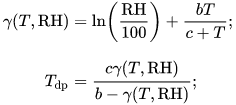

In [ ]:
# calcul du point de rosée  (formule de Heinrich Gustav Magnus-Tetens)
alpha = np.log(rec["OUTHUM"][index]/100.0) + (17.27 * rec["OUTTEMP"][index]) / (237.3 + rec["OUTTEMP"][index])
rosee = (237.3 * alpha) / (17.27 - alpha)

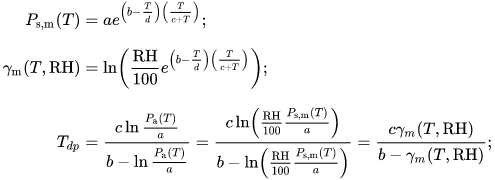

a = 6.1121 mbar, b = 18.678, c = 257.14 °C, d = 234.5 °C.

In [ ]:
rec["id"][index][-1]

In [ ]:
rec[rec["id"]==2023052300215]["OUTTEMP"]

In [ ]:
T = rec["OUTTEMP"][index]
P = rec["OUTPRESS"][index]
RH = rec["OUTHUM"][index]
a = 6.1121
b = 18.678
c = 257.14
d = 234.5
Ps = a * np.exp((b-T/d)*(T/(c+T)))
gamma = np.log((RH/100.) * np.exp((b-T/d)*(T/(c+T))))
dewpoint = c*gamma/(b-gamma)

In [ ]:
fig = plt.figure(figsize=(5.5,4))
col="PWV [mm]_x"
index = filtered & (rec["FILTER"] == 'empty')
plt.errorbar(rec["A1_x"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=filt)
plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
plt.grid()
plt.ylabel("PWV [mm]")
plt.title("Precipitable Water Vapor measured by AuxTel in 2023")
#plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
df.columns.values

In [ ]:
fig = plt.figure(figsize=(5.5,4))
col="A1_x"
index = filtered & (rec["FILTER"] == 'empty')
plt.errorbar(rec["SKY_BGD"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+", label=filt)
plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
plt.grid()
plt.ylabel("PWV [mm]")
plt.title("Precipitable Water Vapor measured by AuxTel in 2023")
#plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
df[df["id"]=="2023092800306"]

In [ ]:
where = "instrument='LATISS' AND visit.day_obs=20230926 AND visit.target_name='HD2811'" 
test_records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
len(test_records)

In [ ]:
specs = []
ids = []
for i, r in enumerate(records):
    #try:
    times.append(r.day_obs)
    spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
    # print(r.id, spec.header["PSF_REG"], spec.header["CHI2_FIT"])
    if spec.header["PSF_REG"] < 3e-2 or spec.header["PSF_REG"] > 0.2:
        continue
    if spec.header["D2CCD"] < 186 or spec.header["D2CCD"] > 188:
        continue
    if spec.header["CHI2_FIT"] > 5:
        continue
    print(r.id, spec.header["PSF_REG"], spec.header["CHI2_FIT"])
    specs.append(spec)
    ids.append(r.id)
    
#specs = specs[np.argsort(ids)]

In [ ]:
fig = plt.figure()
for s in specs:
    plt.plot(s.lambdas, s.data) # /np.sum(s.data)
plt.show()

In [ ]:
ind = df["TARGET"]=="HD2811"
for keyx in ["ozone [db]_x", "VAOD_x", "PWV [mm]_x", "A1_x"]:
    keyy = keyx.replace("_x", "_y")
    fig = plt.figure()
    plt.plot(df[keyx], df[keyy] , '+')
    plt.plot(df[keyx][ind], df[keyy][ind], '+')
    #plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount motion image degradation"] , '+')
    plt.grid()
    #plt.yscale("log")
    #plt.xscale("log")
    plt.xlabel(keyx)
    plt.ylabel(keyy)
    plt.show()

## Correlation with night meta data

In [ ]:
import glob
file_list = glob.glob('night_metadata/*.json')
data_frames = [pd.read_json(file).T for file in sorted(file_list)]
dfn = pd.concat(data_frames)
dfn["id"] = dfn["Exposure id"]
dfn

In [ ]:
dftot = df[filtered].merge(dfn, how="outer", on="id")
#dftot = dftot[dftot["dayObs"]==20231129]
dftot

In [ ]:
ind = dftot["Target"]=="HD2811"
#ind = dftot["Target"]=="HD185975"

fig = plt.figure()
plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount jitter RMS"] , '+')
plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount motion image degradation"] , '+')
plt.grid()
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [ ]:
for keyy in ["y_c_0_1", "y_c_1_1", "y_c_2_1", "y_c_0_2", "y_c_1_2", "y_c_2_2"]:
    for keyx in ["angle [deg]", "shift_y [pix]"]:    
        fig = plt.figure()
        plt.plot(dftot[keyx], dftot[keyy] , '+')
        plt.plot(dftot[ind][keyx], dftot[ind][keyy] , '+')
        #plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount motion image degradation"] , '+')
        plt.grid()
        #plt.yscale("log")
        #plt.xscale("log")
        plt.xlabel(keyx)
        plt.ylabel(keyy)
        plt.show()

In [ ]:
for keyy in ["ozone [db]_y", "A1_y", "VAOD_y", "P [hPa]", "y_c_0_2", "y_c_1_2", "y_c_2_2", "gamma_0_1", "angle [deg]", "shift_y [pix]"]:
    for keyx in ["Mount motion image degradation", "Azimuth", "Altitude", "AIRMASS", "angstrom_exp_y"]:    
        fig = plt.figure()
        plt.plot(dftot[keyx], dftot[keyy] , '+')
        plt.plot(dftot[ind][keyx], dftot[ind][keyy] , '+')
        #plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount motion image degradation"] , '+')
        plt.grid()
        #plt.yscale("log")
        #plt.xscale("log")
        plt.xlabel(keyx)
        plt.ylabel(keyy)
        plt.show()

In [ ]:
for keyy in ["ozone [db]_x", "VAOD_x", "PWV [mm]_x", "A1_x", "A2_x"]:
    for keyx in ["Azimuth", "Altitude", "AIRMASS", "angstrom_exp_x"]:    
        fig = plt.figure()
        plt.plot(dftot[keyx], dftot[keyy] , '+')
        plt.plot(dftot[ind][keyx], dftot[ind][keyy] , '+')
        #plt.plot(dftot[ind]["Airmass"], dftot[ind]["Mount motion image degradation"] , '+')
        plt.grid()
        #plt.yscale("log")
        #plt.xscale("log")
        plt.xlabel(keyx)
        plt.ylabel(keyy)
        plt.show()

## Filtering

In [ ]:
pd.set_option('display.max_columns', None)
test = df.query('id>=2023092800266 & id<=2023092800267 & TARGET=="HD160617"')
test[:]

In [ ]:
from spectractor.fit.fit_spectrogram import SpectrogramFitWorkspace, run_spectrogram_minimisation
from spectractor.fit.fit_spectrum import SpectrumFitWorkspace, run_spectrum_minimisation
from spectractor.extractor.spectrum import Spectrum
from spectractor import parameters
import shutil
import os
os.environ["PATH"] = "/sdf/group/rubin/u/jneveu/.conda/envs/jneveu-lsst-scipipe-6.0.0/bin/"
os.environ["CONDA_PREFIX"] = "/sdf/group/rubin/u/jneveu/.conda/envs/jneveu-lsst-scipipe-6.0.0"
shutil.which('uvspec')

dataId = {"day_obs": 20230511, "seq_num": 248, 'instrument':'LATISS',"detector": 0}
spec= butler.get('spectractorSpectrum',dataId,collections=my_collection)
spec.plot_spectrum()

In [ ]:
parameters.VERBOSE = True
parameters.DEBUG = True
w = SpectrumFitWorkspace(spec, atmgrid_file_name='', verbose=True, plot=True, live_fit=False, fit_angstrom_exponent=False)
run_spectrum_minimisation(w, method="newton")
w.params.print_parameters_summary()